## Assignment 3

#### Alex Sung-Min Hong
NetID: smh802

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import scipy.io
import scipy.signal
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### 1. Image Alignment

In [2]:
image2 = cv2.imread('./scene.pgm')
image1 = cv2.imread('./book.pgm')

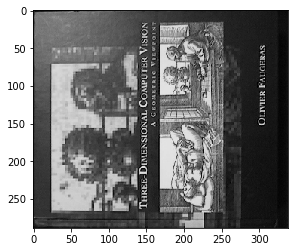

In [3]:
plt.imshow(image1)

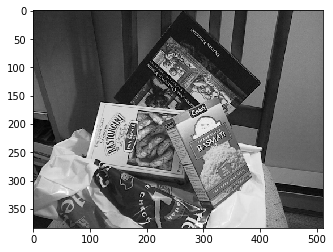

In [4]:
plt.imshow(image2)

• Find local image regions in each image

• Characterize the local appearance of the regions

• Get set of putative matches between region descriptors in each image

• Perform RANSAC to discover best transformation between images

In [5]:
def SIFT(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None) #kp: list of keypoint, des: numpy array of (kp * 128) 128 = 16 * 8
    cv2.drawKeypoints(gray, kp, img)
    plt.imshow(img)
    
    return gray, kp, des

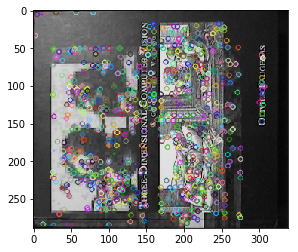

In [6]:
gray1, kp1, des1 = SIFT(image1)

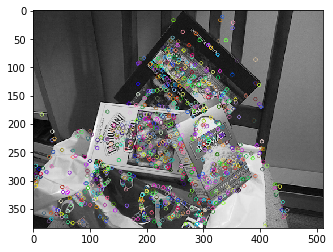

In [7]:
gray2, kp2, des2 = SIFT(image2)

The next step is to obtain a set of putative matches T. This should be done as follows: for each descriptor in image 1, compute the closest neighbor amongst the descriptors from image 2 using Euclidean distance. Spurious matches can be removed by then computing the ratio of distances between the closest and second-closest neighbor and rejecting any matches that are above a certain threshold. To test the functioning of RANSAC, we want to have some erroneous matches in our set, thus this threshold should be set to a fairly slack value of 0.9. To check that your code is functioning correctly, plot out the two images side-by-side with lines showing the potential matches (include this in your report).

In [8]:
threshold = 0.9

# reference: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher
# Euclidean Distance
bf = cv2.BFMatcher() # by default L2 Norm

# match descriptors
matches = bf.knnMatch(des1, des2, k=2)

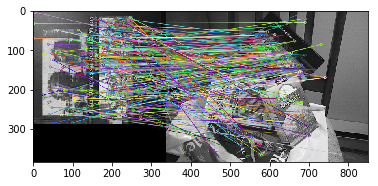

In [9]:
# Ratio test: spurious matches that are above a certain threshold should be removed.
candidates = []
for x,y in matches:
    if x.distance < y.distance * threshold:
        candidates.append([x])

img3 = cv2.drawMatchesKnn(gray1, kp1, gray2, kp2, candidates, 0, flags =2)
plt.imshow(img3)

In [10]:
len(matches), len(candidates)

(848, 244)

The final stage, running RANSAC, should be performed as follows:

• Repeat N times (where N is ∼100):

• Pick P matches at random from the total set of matches T. Since we are solving for an affine transformation which has 6 degrees of freedom, we only need to select P=3 matches.

• Construct a matrix A and vector b using the 3 pairs of points as described in lecture 6.

• Solve for the unknown transformation parameters q. In Matlab you can use the \ command. In Python you can use linalg.solve.

• Using the transformation parameters, transform the locations of all T points in image 1. If the transformation is correct, they should lie close to their pairs in image 2.

• Count the number of inliers, inliers being defined as the number of transformed points from image 1 that lie within a radius of 10 pixels of their pair in image 2.

• If this count exceeds the best total so far, save the transformation parameters and the set of inliers.

• End repeat.

• Perform a final refit using the set of inliers belonging to the best transformation you found. This refit should use all inliers, not just 3 points chosen at random.

• Finally, transform image 1 using this final set of transformation parameters, q. In Matlab this can be done by first forming a homography matrix H = [ q(1) q(2) q(5) ; q(3) q(4) q(6) ; 0 0 1 ]; and then using the imtransform and maketform functions as follows: transformed image=imtransform(im1,maketform(’affine’,H’));. In Python you can use the cv2.warpAffine from the OpenCV-Python environment. If you display this image you should find that the pose of the book in the scene should correspond to its pose in image 2.

In [11]:
res_count = 0
res_inliers = set()

for i in range(100):
    # pick three random different points
    three = np.random.choice(len(candidates), 3, replace=False)

    q1 = kp1[candidates[three[0]][0].queryIdx]
    q2 = kp1[candidates[three[1]][0].queryIdx]
    q3 = kp1[candidates[three[2]][0].queryIdx]

    t1 = kp2[candidates[three[0]][0].trainIdx]
    t2 = kp2[candidates[three[1]][0].trainIdx]
    t3 = kp2[candidates[three[2]][0].trainIdx]

    # Matrix A for Affine transformations (lecture note 97) A: 6*6, At = b
    # slide 97
    A = np.array([
                [*q1.pt, 1, 0, 0, 0 ],
                [0, 0, 0, *q1.pt, 1],
                [*q2.pt, 1, 0, 0, 0 ],
                [0, 0, 0, *q2.pt, 1],
                [*q3.pt, 1, 0, 0, 0 ],
                [0, 0, 0, *q3.pt, 1],])

    b = np.array([*t1.pt, *t2.pt, *t3.pt])

    # Solve for the unknown transformation parameters q

    trans = np.linalg.solve(A,b)

    count = 0
    inliers = set()

    for match in candidates:
        # Using the transformation parameters, transform the locations of all T points in image 1.
        transformed = np.array([[*kp1[match[0].queryIdx].pt, 1, 0, 0, 0],[0, 0, 0, *kp1[match[0].queryIdx].pt, 1]]).dot(trans)
        # Count the number of inliers, inliers being defined as the number of transformed points from image 1 
        # that lie within a radius of 10 pixels of their pair in image 2.
        if np.linalg.norm(transformed - kp2[match[0].trainIdx].pt) < 10:
            count +=1
            inliers.add(match[0])
        #print(count)
            
    # If this count exceeds the best total so far, save the transformation parameters and the set of inliers.
    if count > res_count:
        res_count = count
        res_inliers = inliers

print("Number of inliers in best transformation:", res_count)

Number of inliers in best transformation: 114


In [12]:
# Perform a final refit using the set of inliers belonging to the best trans- formation you found. 
# This refit should use all inliers, not just 3 points chosen at random.
# A = 2n X 6, b = 2n X 1
A = np.zeros((res_count*2, 6))
b = np.zeros(res_count*2)

for i in range(res_count):
    A[2*i, 0:2] = kp1[list(res_inliers)[i].queryIdx].pt
    A[2*i+1, 3:5] = kp1[list(res_inliers)[i].queryIdx].pt
    A[2*i,2] = 1
    A[2*i+1, 5] = 1
    
    b[2*i:2*i + 2] = kp2[list(res_inliers)[i].trainIdx].pt

In [13]:
homography, _, _, _ = np.linalg.lstsq(A, b, rcond=-1)

In [14]:
homography = homography.reshape(2,3)

Matrix of H

In [15]:
homography

array([[  0.40030239,   0.45097301, 135.3658547 ],
       [ -0.45825511,   0.41731429, 155.92252584]])

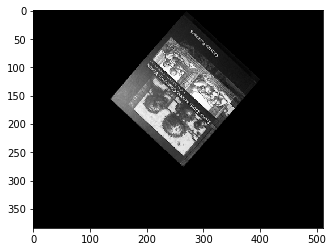

In [16]:
# Finally, transform image 1 using this final set of transformation parameters, q. 
# In Python you can use the cv2.warpAffine from the OpenCV-Python environment. 
# If you display this image you should find that the pose of the book in the scene should 
# correspond to its pose in image 2.
# >>> this implies that the image1 and image2 in description is wrong, image1=book, image2= scene
ransac = cv2.warpAffine(gray1, homography, gray2.T.shape)
plt.imshow(ransac, cmap='gray')

### 2. Estimating the camera parameters 

In [17]:
image = np.loadtxt('./image.txt')
world = np.loadtxt('./world.txt')

In [18]:
image

array([[ 5.11770701,  5.5236545 ,  7.16310171,  5.22216628,  5.60479614,
        13.59494885,  8.73452189,  6.22433952,  9.74763886,  5.09031079],
       [ 4.76538441,  3.87032917,  7.35942066,  4.4279585 ,  4.67483648,
        10.05215495,  5.56420531,  3.90821885,  6.90423723,  4.5508513 ]])

In [19]:
world

array([[0.8518447 , 0.55793851, 0.81620571, 0.70368367, 0.71335444,
        0.1721997 , 0.04904683, 0.28614965, 0.13098247, 0.84767647],
       [0.75947939, 0.01423302, 0.97709235, 0.52206092, 0.2280389 ,
        0.96882014, 0.75533857, 0.25120055, 0.94081954, 0.20927164],
       [0.94975928, 0.59617708, 0.22190808, 0.93289706, 0.4496421 ,
        0.3557161 , 0.89481276, 0.93273619, 0.70185317, 0.45509169]])

#### (a) Find the 3x4 matrix P that projects the world points X to the 10 image points x. This should be done in the following steps:

In [20]:
# Since P is a homogeneous matrix, the world and image points (which are 3 and 2-D respectively),
# need to be converted into homogeneous points by concatenating a 1 to each of them 
# (thus becoming 4 and 3-D respectively).
x = np.vstack((image, np.ones((1,10))))
X = np.vstack((world, np.ones((1,10))))

In [21]:
# We now note that x × P X = 0, irrespective of the scale ambiguity.
# But since the 3rd row is a linear combination of the first two,
# we need only consider the first two rows for each correspondence i.
# Thus, you should form a 20 by 12 matrix A, each of the 10 correspondences contributing two rows. 
# This yields Ap = 0, p being the vector containing the entries of matrix P.
A = np.zeros((20, 12))

for i in range(10):
    xi, yi, wi = x.T[i]
    
    A[i][4:8] = -wi * X.T[i]
    A[i][8:12] = yi * X.T[i]
    A[i+10][0:4] = wi * X.T[i]
    A[i+10][8:12] = -xi * X.T[i]
    
# this yields Ap = 0, p being the vector containing the entries of matrix P.

In [22]:
U, s, V = np.linalg.svd(A)

In [23]:
# smallest eigenvector
P = V[-1].reshape(3,4)

In [24]:
P

array([[ 1.27000127e-01,  2.54000254e-01,  3.81000381e-01,
         5.08000508e-01],
       [ 5.08000508e-01,  3.81000381e-01,  2.54000254e-01,
         1.27000127e-01],
       [ 1.27000127e-01,  1.69126602e-16,  1.27000127e-01,
        -3.97727703e-16]])

In [25]:
P.shape, X.shape

((3, 4), (4, 10))

In [26]:
# Verify your answer by re-projecting the world points X and checking that they are close to x.
reproj = P @ X # (X.T @ p.T).T is equivalent to P @ T
for i in range(10):
    reproj[0][i] = reproj[0][i]/ reproj[-1][i]
    reproj[1][i] = reproj[1][i]/ reproj[-1][i]
    reproj[2][i] = reproj[2][i]/ reproj[2][i]
reproj

array([[ 5.11770701,  5.5236545 ,  7.16310171,  5.22216628,  5.60479614,
        13.59494885,  8.73452189,  6.22433952,  9.74763886,  5.09031079],
       [ 4.76538441,  3.87032917,  7.35942066,  4.4279585 ,  4.67483648,
        10.05215495,  5.56420531,  3.90821885,  6.90423723,  4.5508513 ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

In [27]:
x

array([[ 5.11770701,  5.5236545 ,  7.16310171,  5.22216628,  5.60479614,
        13.59494885,  8.73452189,  6.22433952,  9.74763886,  5.09031079],
       [ 4.76538441,  3.87032917,  7.35942066,  4.4279585 ,  4.67483648,
        10.05215495,  5.56420531,  3.90821885,  6.90423723,  4.5508513 ],
       [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ]])

It is observed that re-projecting the world points X is almost same as x.

#### (b) Now we have P, we can compute the world coordinates of the projection center of the camera C. Note that PC = 0, thus C lies in the null space of P, which can again be found with an SVD (the Matlab command is svd). Compute the SVD of P and pick the vector corresponding to this null-space. Finally, convert it back to inhomogeneous coordinates and to yield the (X,Y,Z) coordinates. Your report should contain the matrix P and the value of C. 


Matrix of P

In [28]:
P

array([[ 1.27000127e-01,  2.54000254e-01,  3.81000381e-01,
         5.08000508e-01],
       [ 5.08000508e-01,  3.81000381e-01,  2.54000254e-01,
         1.27000127e-01],
       [ 1.27000127e-01,  1.69126602e-16,  1.27000127e-01,
        -3.97727703e-16]])

In [29]:
# PC = 0
C = np.linalg.svd(P)[-1][-1]

In [30]:
C

array([-0.5,  0.5,  0.5, -0.5])

Finally, convert it back to inhomogeneous coordinates and to yield the (X,Y,Z) coordinates. (Cartesian)

In [31]:
C_inhomo = np.asarray(([C[0]/C[3], C[1]/C[3], C[2]/C[3]]))
C_inhomo

array([ 1., -1., -1.])

In the alternative route, we decompose P into it’s constituent matrices. Recall from the lectures that P = K[R|t]. However, also, t = −RC, C being the inhomogeneous form of C. Since K is upper triangular, use a RQdecomposition to factor KR into the intrinsic parameters K and a rotation matrix R. Then solve for C. Check that your answer agrees with the solution from the first method.

In [32]:
# using mode of 'economic' so that the shapes of Q and R are (K, N) and (M, K) 
# instead of (N,N) and (M,N), with K=min(M,N).
K, Q = scipy.linalg.rq(P, mode='economic')
K

array([[-0.51847585,  0.29329423,  0.3592106 ],
       [ 0.        ,  0.43994135,  0.53881591],
       [ 0.        ,  0.        ,  0.1796053 ]])

In [33]:
Q

array([[ 4.08248290e-01, -6.74430157e-16, -4.08248290e-01,
        -8.16496581e-01],
       [ 2.88675135e-01,  8.66025404e-01, -2.88675135e-01,
         2.88675135e-01],
       [ 7.07106781e-01,  9.41657066e-16,  7.07106781e-01,
        -2.22044605e-15]])

In [34]:
K.shape, Q.shape

((3, 3), (3, 4))

In [35]:
# P = K [R|t] = RQ_decomposition(P)
# Q = [R|t]
# Q[:,-1] = t
# t= -R_ @ C
t = Q[:,-1]
t

array([-8.16496581e-01,  2.88675135e-01, -2.22044605e-15])

In [36]:
R_ = Q[:,:-1]

In [37]:
C = np.linalg.solve(-R_,t)
C

array([ 1., -1., -1.])

The C from alternative route is as same as the one from previous method.

### 3. Structure from Motion

In [38]:
image_points = scipy.io.loadmat('./sfm_points.mat')['image_points']

In [39]:
image_points.shape

(2, 600, 10)

Try plotting out several frames and the cube shaped structure should be apparent

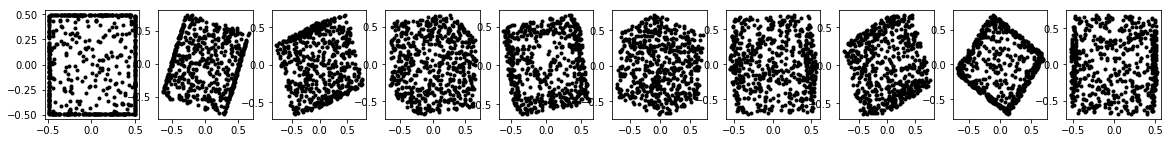

In [40]:
_, axarr = plt.subplots(1, 10, figsize= (20,2))
for i in range(10):
    axarr[i].plot(*image_points[:,:,i],'.', color='black')

In [41]:
# Compute the translations t^i directly by computing the centroid of point in each image i.
x_centroids = np.mean(image_points[0], axis=0)
y_centroids = np.mean(image_points[1], axis=0)
t = np.vstack((x_centroids, y_centroids))

In [42]:
# Center the points in each image by subtracting off the centroid, so that the points have zero mean
for i in range(10):
    image_points[0][i] -= t[0][i]
    image_points[1][i] -= t[1][i]

In [43]:
image_points.shape

(2, 600, 10)

Construct the 2m by n measurement matrix W from the centered data.

In [44]:
# each column consists of x_0, y_0, x_1, y_0,...x_m, y_m
W = np.ones((20,600))
for i in range(600):
    W[::2,i] = image_points[0,i]
    W[1::2,i] = image_points[1,i]

In [45]:
# Perform an SVD decomposition of W into UDV^T
U, s, V = np.linalg.svd(W)

In [46]:
# The camera locations Mi can be obtained from the first three columns
# of U multiplied by D(1 : 3, 1 : 3), the first three singular values.
M = np.dot(U[:,0:3], np.diag(s[0:3])) # spread three signular values to diagonal matrix and get dot product

In [47]:
# The 3D world point locations are the first three columns of V .
threeD_pts = V[:3]

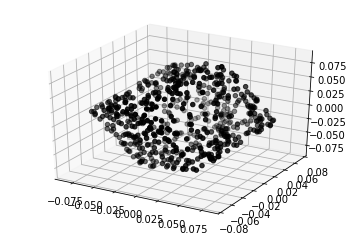

In [48]:
# You can verify your answer by plotting the 3D world points out using the plot3 command. 
# The rotate3d command will let you rotate the plot. 
# This functionality is replicated in Python within the matplotlib package.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*threeD_pts, color='black')

The script should print out the $M^i$ and $t^i$ for the first camera and also the 3D coordinates of the first 10 world points.

$M^i$ for the first camera

In [49]:
M[:2,:]

array([[-7.50914219,  3.30837904, -3.71763726],
       [-4.53754376, -1.57773527,  7.74574759]])

$t^i$ for the first camera

In [50]:
t[:,0]

array([2.36847579e-17, 8.28966525e-17])

The 3D coordinates of the first 10 world points

In [51]:
threeD_pts[:,:10].T

array([[ 0.00577163,  0.06460628, -0.02497615],
       [ 0.0005761 ,  0.06885363, -0.03458151],
       [-0.04293585,  0.06330479,  0.02861711],
       [ 0.04745038,  0.04904207, -0.01257547],
       [-0.04210186,  0.06789239,  0.01175164],
       [ 0.05961964,  0.0460518 , -0.01438374],
       [ 0.00909167,  0.06002049, -0.01229997],
       [ 0.01039489,  0.04602065,  0.03529275],
       [-0.02589081,  0.05702972,  0.03337375],
       [ 0.01745598,  0.04054264,  0.04731859]])